# Swanalytics - Swan Telecom 

Using Decision Trees and Random Forest to make predictions on customers most likely to churn 

In [40]:
# core four
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split # train test

## Import the metrics we'll be using
from sklearn import metrics
## Import Logistic Regression from sklearn



# DT 
from sklearn import metrics
from time import time # to measure how long it takes to run models

# modelling stuff
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score) # conf matrix and accuracy
from sklearn.model_selection import cross_val_score


# Random Forest
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ET

In [62]:
df = pd.read_csv('https://raw.githubusercontent.com/gdiwa23/Swanalytics/refs/heads/main/1%20Project%20Data%20-%20Telco_Churn.csv')

### first look at data

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum() / len(df) * 100

In [ ]:
df.columns

*  After a first look at the data, the following actions must be taken to clean up the df, in preparation for train test splitting

In [63]:
df = df.drop(columns=["Count","City","Country","State","Lat Long","Churn Label","Churn Reason"]) # drop columns we don't want to use 

In [64]:
# Total charges needs to be cast to float

df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce') # casts to float
df['Total Charges'] = df['Total Charges'].fillna(0) # found NaN values after casting -> fill with 0
df['Total Charges'].isnull().sum() # check = 0 nulls

0

In [65]:
df.set_index('CustomerID', inplace=True) # set as index, checked all are unqiue first

### Train test split

In [66]:
# set feature columns
feature_cols = df.columns.drop('Churn Value')
feature_cols

Index(['Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges'],
      dtype='object')

In [67]:
# set X and y 
X = df[feature_cols].copy()  # features
y = df['Churn Value']   

In [68]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 1)

In [69]:
# sanity checks
print(f'Train match: {len(X_train)==len(y_train)}')
print(f'Test match: {len(X_test)==len(y_test)}')

Train match: True
Test match: True


### Data Cleaning 

In [70]:
# looking at the nulls on a seprate notebook, will update on here

def clean_data(df):

  assert isinstance(df, pd.DataFrame), 'Parameter needs to be a DataFrame'
    
  df_clean = df.copy() # df is X


  # OHE the service column into Fibre Optic or DSL - 0 in both indicates no internet service
    
  service_dummies = pd.get_dummies(df_clean['Internet Service'], prefix='Service', drop_first=True, dtype=int)
  df_clean = pd.concat([df_clean, service_dummies], axis=1)
  df_clean = df.drop(columns=['Internet Service'])

  df_clean = pd.get_dummies(df_clean, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype = int)
  df_clean = pd.get_dummies(df_clean, columns=['Payment Method'], drop_first=True, prefix='Payment_Method', dtype=int)


    
  # Label Encoding

  df_clean['Gender'] = df_clean['Gender'].map({'Female': 0, 'Male':1, 0:0, 1:1})
  df_clean['Senior Citizen'] = df_clean['Senior Citizen'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  df_clean['Partner'] = df_clean['Partner'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  df_clean['Dependents'] =  df_clean['Dependents'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  df_clean['Phone Service'] = df_clean['Phone Service'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  df_clean['Multiple Lines'] = df_clean['Multiple Lines'].map({'No': 0, 'Yes':1,'No phone service':0, 0:0, 1:1})

  df_clean['Online Security'] = df_clean['Online Security'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
  df_clean['Online Backup'] = df_clean['Online Backup'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
  df_clean['Device Protection'] = df_clean['Device Protection'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
  df_clean['Tech Support'] = df_clean['Tech Support'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})

  #TV - No internet service has been combined with No
  df_clean['Streaming TV'] = df['Streaming TV'].replace(['No internet service', 'No'], 'No')
  df_clean['Streaming TV'] = df_clean['Streaming TV'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  # Movies- No internet service has been combined with No
  df_clean['Streaming Movies'] = df['Streaming Movies'].replace(['No internet service', 'No'], 'No')
  df_clean['Streaming Movies'] = df_clean['Streaming Movies'].map({'No': 0, 'Yes':1, 0:0, 1:1})
  # Paperless Billing
  df_clean['Paperless Billing'] = df_clean['Paperless Billing'].map({'No': 0, 'Yes':1, 0:0, 1:1})




  return df_clean

#### clean the data using the function

In [71]:
X_train_fe = clean_data(X_train)

In [17]:
X_test_fe = clean_data(X_test)

In [72]:
## no churn DATA TO PREDICT ON 
df_nochurn = df[df['Churn Value'] ==  0]
df_nochurn = df_nochurn.drop(columns=["Churn Value"])

In [73]:
df_nochurn = df_nochurn[feature_cols]
df_nochurn_fe = clean_data(df_nochurn)

In [74]:
# sanity checks - just to make sure all good

print(f'Train post split match: {len(X_train_fe)==len(y_train)}')
print(f'Test post split match: {len(X_test_fe)==len(y_test)}\n')

print(f'Train post data cleaning match: {X_train_fe.shape[0] == X_train.shape[0]}')
print(f'Test post data cleaning match: {X_test_fe.shape[0] == X_test.shape[0]}\n')

print(f'Churn data post cleaning match: {df_nochurn_fe.shape[0]==df_nochurn.shape[0]}')


Train post split match: True
Test post split match: True

Train post data cleaning match: True
Test post data cleaning match: True

Churn data post cleaning match: True


### Decision Tree + Grid Search

* Start with the initial decision tree and use as benchmark.

* The decision tree achieves a solid 79% accuracy on the training set, but deeper analysis reveals that while precision is acceptable at 68%, recall is significantly lower at 42%. This suggests the model is better at correctly identifying churners when it predicts churn BUT misses a large portion of actual churners. Improving recall and precision are key in order to maximise the models ability to predict churners.
* With a limited slot of just Top 500 to deliver to the Marketing Team, we need to focus on Precision and Recall as metrics to ensure that the model captures customers who are most likely to churn.
* This leads into the use of grid search to optimise parameters


> Decision Tree Key Metrics: Train Set  
> 
> Accuracy:   0.7903798367057153  
> Precision:  0.6801705756929638  
> Recall:     0.42001316655694537  
> F1:         0.5193325193325193

In [75]:
# first decision tree
dt = DecisionTreeClassifier(max_depth=4, # initially 3, but changed to 4 and saw improvement
                            random_state=2)
dt.fit(X_train_fe, y_train) #fit data to model

DecisionTreeClassifier(max_depth=4, random_state=2)

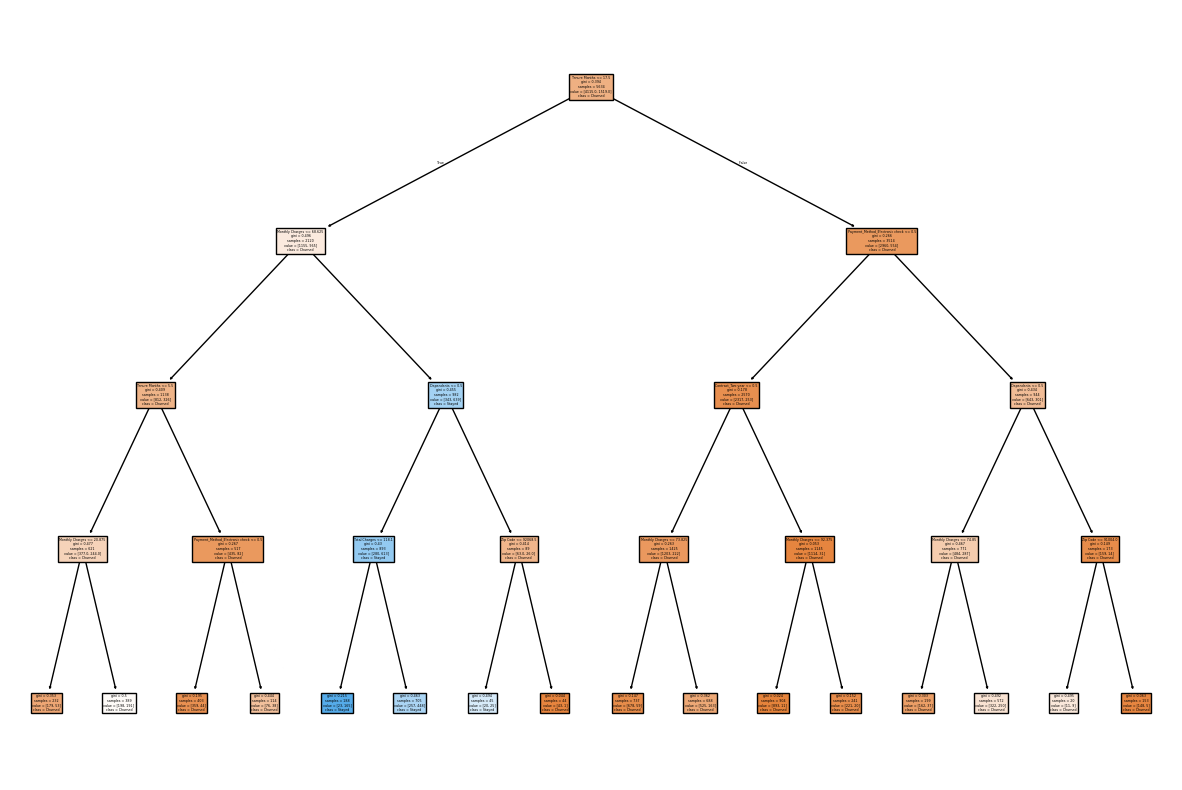

In [76]:
# plot the first tree
fig = plt.figure(figsize=(15,10))
tree_1 = tree.plot_tree(dt,
                   feature_names=X_train_fe.columns,
                   class_names=['Churned', 'Stayed'],
                   filled=True)
plt.show()

In [77]:
## accuracy score
print(f'Score on training set: {dt.score(X_train_fe, y_train)}')
print(f'Score on testing set: {dt.score(X_test_fe, y_test)}')

Score on training set: 0.7903798367057153
Score on testing set: 0.7998580553584103


In [78]:
def apr(y_real, y_pred):
    """ Calculates accuracy, precision, recall
        Requires predicted value first, and then the real value
    """
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)

    print(f"Accuracy:   {accuracy}")
    print(f"Precision:  {precision}")
    print(f"Recall:     {recall}")
    print(f"F1:         {f1}")
    #return accuracy, precision, recall, f1

In [79]:
# Decision tree 1 key metrics 

y_pred_dt = dt.predict(X_train_fe) # add y_pred col # decision tree pred
print('Decision Tree Key Metrics: Train Set\n')
apr(y_train, y_pred_dt)

Decision Tree Key Metrics: Train Set

Accuracy:   0.7903798367057153
Precision:  0.6801705756929638
Recall:     0.42001316655694537
F1:         0.5193325193325193


#### Grid Search with DT
* To improve on the intial results of the dt, we are using grid search in order to optimise the hyperparameters used in the model
* cv = 10 , means that the grid search will cross validate across 10 slices the data 
* grid search will give us the .best_estimator_ which will be used to train the data

*The Random Forest model achieves an accuracy of 80.7%, indicating solid overall performance. With a precision of 63.8%, it reliably identifies actual churners when it predicts churn. A recall of 65.1% shows the model captures a good portion of actual churn cases, better than the decision tree. The F1 score of 64.5% reflects a balanced trade-off, making this model suitable for churn detection with moderate risk tolerance.

>  Decision Tree (+GridSearch) Key Metrics: Train Set
> * Accuracy:   0.8065317713880015
> * Precision:  0.6384764364105875
> * Recall:     0.6510862409479921
> * F1:         0.6447196870925684

In [116]:
# grid searach
grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state=2),
                                   param_grid = {'max_depth': [3, 4, 5, 7, 10],                   # the options you want to explore
                                  'min_samples_split': [10, 50, 100, 150, 200], # ''
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7],        # ''
                                  'max_features':[2, 3, 4, 5, 6, 7, 8, 10, 12]},      # number of features to use                       ## up max features later
                    cv = 5,              # 10 folds, cross validate 10 times
                    refit = True,         # refitting = retraining on the K folds , cross validation, swaps
                    verbose = 1,          # how much we get told about what went on in the gridsearch
                    scoring = 'recall') # changed to recall to maximise this

In [117]:
# timer, to see how long model takes to finish
now = time()

# fit the model
grid.fit(X_train_fe, y_train)     # time between pressing run and model finishing
print(f' Time in seconds: {time() - now}')

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
 Time in seconds: 47.38520383834839


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [118]:
# the best version of the DT according to gridsearch -> grid.best_estimator_

dt_best_estimator = grid.best_estimator_ # train dt model on grid best estimator
dt_best_estimator.fit(X_train_fe, y_train)

DecisionTreeClassifier(max_depth=7, max_features=7, min_samples_leaf=3,
                       min_samples_split=10, random_state=2)

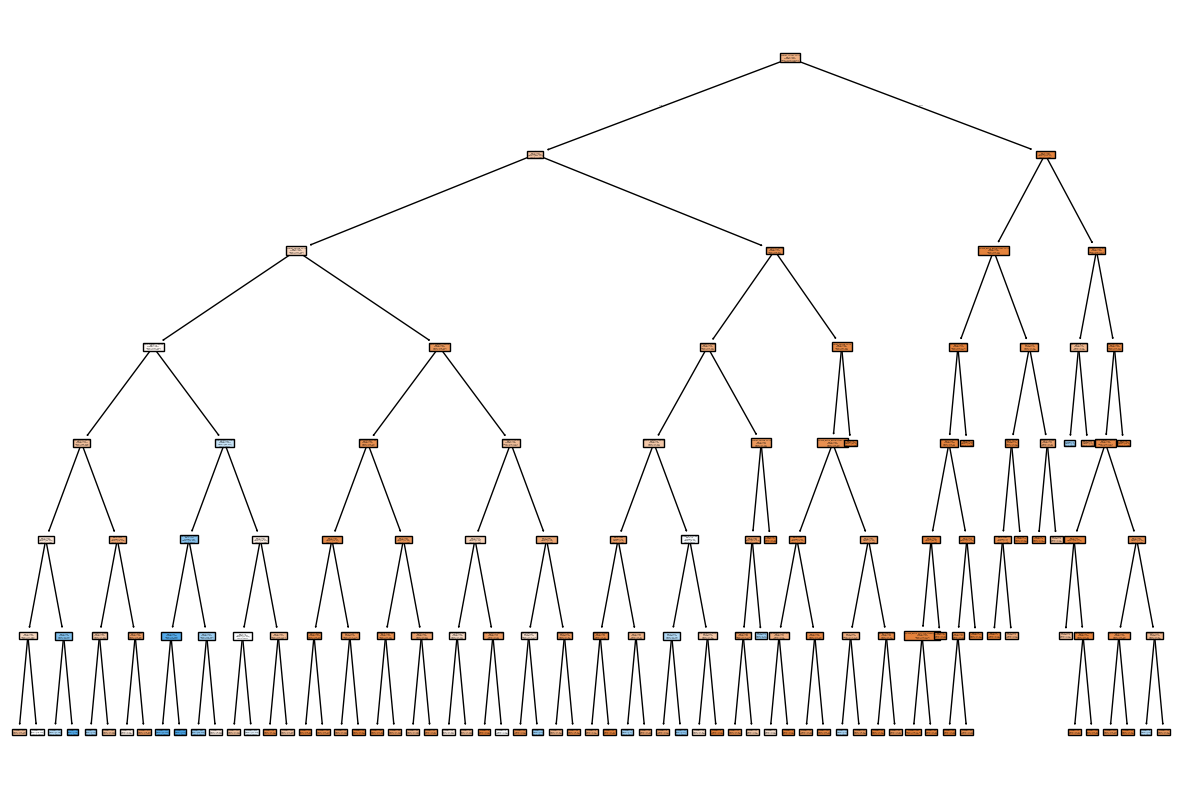

In [119]:
# dt_best_estimator tree plot

fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(dt_best_estimator,
                   feature_names=X_train_fe.columns,
                   class_names=['Churned', 'Stayed'],
                   filled=True)

In [114]:
# score for training and test

print(f'Score on training set: {dt_best_estimator.score(X_train_fe, y_train)}')
print(f'Score on testing set: {dt_best_estimator.score(X_test_fe, y_test)}')

Score on training set: 0.8065317713880015
Score on testing set: 0.7799858055358411


In [120]:
# Key metrics for Decision Tree + GridSearch

y_pred_dt_best_estimator = dt_best_estimator.predict(X_train_fe) # add y_pred col # decision tree pred
print('Decision Tree (+GridSearch) Key Metrics: Train Set\n')
apr(y_train, y_pred_dt_best_estimator)

Decision Tree (+GridSearch) Key Metrics: Train Set

Accuracy:   0.8065317713880015
Precision:  0.6384764364105875
Recall:     0.6510862409479921
F1:         0.6447196870925684


#### DT feature importances

* Feature importances informs us which features had the most influence in producing the model's predictions.
> Top 10 Feature importances 
> * Monthly Charges: 0.2597
> * Payment Method: 0.1938
> * Dependents: 0.1410
> * Contract: 0.1328
> * Paperless Billing: 0.0932
> * Tenure Months: 0.0490
> * Streaming Movies: 0.0210
> * Device Protection: 0.0189
> * Latitude: 0.0177
> * Longitude: 0.0173

In [122]:
# view feature importance ## same as before gs

dt_best_estimator.feature_importances_

# Pair feature names with their importance values
importance = list(zip(feature_cols, dt_best_estimator.feature_importances_))

# Sort the list by importance in descending order
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

# Display
for feature, score in importance_sorted:
    print(f"{feature}: {score:.4f}")

## most important features according to the decision tree

Monthly Charges: 0.2597
Payment Method: 0.1938
Dependents: 0.1410
Contract: 0.1328
Paperless Billing: 0.0932
Tenure Months: 0.0490
Streaming Movies: 0.0210
Device Protection: 0.0189
Latitude: 0.0177
Longitude: 0.0173
Zip Code: 0.0135
Senior Citizen: 0.0130
Phone Service: 0.0088
Internet Service: 0.0086
Tech Support: 0.0041
Streaming TV: 0.0018
Online Security: 0.0015
Multiple Lines: 0.0007
Gender: 0.0005
Partner: 0.0001
Total Charges: 0.0001
Online Backup: 0.0000


In [123]:
importance_df = pd.DataFrame(importance_sorted, columns=["feature", "score"])
importance_df['score'] = round(importance_df['score'] * 100, 2)

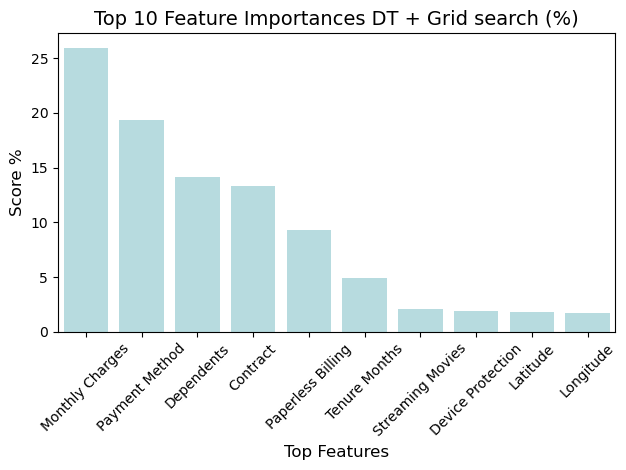

In [124]:
# barplot plotting the top 10 features 
sns.barplot(data=importance_df, x=importance_df['feature'][:10], y='score', color = 'powderblue')

plt.xticks(rotation=45)  # Optional: rotate x-axis labels
plt.xlabel('Top Features', fontsize=12)
plt.ylabel('Score %', fontsize=12)
plt.title('Top 10 Feature Importances DT + Grid search (%)', fontsize=14)
plt.tight_layout()       # Optional: improve layout
plt.show()

### Random Forest

* 

In [106]:
# initialise the model
rf = RF(n_estimators=100, max_depth=9, random_state=2) # 50 trees, 4 levels of questions

In [107]:
# fit the model
rf.fit(X_train_fe, y_train)

RandomForestClassifier(max_depth=9, random_state=2)

In [108]:
# get the  accuracy score ! cv = five k fold cross validation !
rf_score = cross_val_score(rf, X_train_fe, y_train, cv=10)

print(f'The accuracy of RF is: {rf_score}\n') # all the 10 cv folds
print(f'The mean accuracy of RF is: {rf_score.mean()}') # the mean of the 5

The accuracy of RF is: [0.80141844 0.80141844 0.78546099 0.82092199 0.78507993 0.80284192
 0.81882771 0.81172291 0.8312611  0.79396092]

The mean accuracy of RF is: 0.8052914351939332


* grid search on Random Forest

In [ ]:
# gridsearch on RF ---- maybe do more on these parameters ! 

rf_params = {
    'n_estimators': [100, 150, 200, 250], #number of trees in the forest
    'max_depth': [2, 4, 6, 7, 8, 9, 10], # depth of each indiv tree ## can further add the other parameters from before
}


In [ ]:
# initialise and fit + performance timer hehe
now = time()

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, refit=True)
gs.fit(X_train_fe, y_train)

print(f' Time in seconds: {time() - now}')

In [ ]:
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
rf_best_estimator = gs.best_estimator_
print(f'RF train accuracy: {rf_best_estimator.score(X_train_fe, y_train)}')
# Use it to score on the testing set
print(f'RF test accuracy: {rf_best_estimator.score(X_test_fe, y_test)}')

## accuracy is better than the single decision tree (.81, train)

In [ ]:
# Key metrics for Random + GridSearch
X_train_rf_results = X_train_fe.copy()


y_pred_rf_best_estimator = rf_best_estimator.predict(X_train_fe) # add y_pred col # decision tree pred

X_train_rf_results['y_pred'] = y_pred_rf_best_estimator

print('Random Forest (+GridSearch) Key Metrics: Train Set\n')
apr(y_train, y_pred_rf_best_estimator)

In [38]:
# view feature importance ## same as before gs

rf_best_estimator.feature_importances_

# Pair feature names with their importance values
importance_rf = list(zip(feature_cols, rf_best_estimator.feature_importances_))

# Sort the list by importance in descending order
importance_sorted_rf = sorted(importance_rf, key=lambda x: x[1], reverse=True)

# Display
for feature, score in importance_sorted_rf:
    print(f"{feature}: {score:.4f}")

## most important features according to the decision tree

NameError: name 'rf_best_estimator' is not defined

In [ ]:
importance_rf_df = pd.DataFrame(importance_sorted_rf, columns=["feature", "score"])
importance_rf_df['score'] = round(importance_rf_df['score'] * 100, 2)

In [ ]:
sns.barplot(data=importance_rf_df, x=importance_rf_df['feature'][:10], y='score', color = 'powderblue')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels
plt.tight_layout()       # Optional: improve layout
plt.show()

## Final Predictions using RF and Grid Search
* top 500 most likely to leave the service have been identified
* using a Random Forest model train on X_train_fe, combined with Grid Search to optimise the hyperparameters 

In [ ]:
df_nochurn = df[df['Churn Value'] ==  0]
df_nochurn = df_nochurn.drop(columns=["Churn Value"])

In [ ]:
# copy df
rf_results = df_nochurn_fe.copy()
# predict on no churn
rf_results[['P No Churn','P Churn']] = rf_best_estimator.predict_proba(df_nochurn_fe)

In [ ]:
# add y pred to results
y_pred_rf_best_estimator = rf_best_estimator.predict(df_nochurn_fe) # add y_pred col # decision tree pred
rf_results['y_pred'] = y_pred_rf_best_estimator

In [ ]:
# "y_pred","P Churn", "P No Churn"
rf_results = rf_results[["y_pred","P Churn", "P No Churn"]]
# sort values by 500 
rf_results = rf_results.sort_values(by=['P Churn'] , ascending=False)

In [ ]:
rf_results.head()

In [ ]:
# save results to csv - top 500 churners by probability from existing customers existing customers, model trained on X_train_fe

# rf_results.head(500).to_csv('top500_RF.csv', index=True)